In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import scipy.special
import cv2

import torch

import networkx as nx

import pickle
from PIL import Image
import matplotlib.lines as lines
import tqdm
import glob

import statistics 


from skimage.transform import rotate
from sklearn.neighbors import KDTree
from scipy.spatial import distance

np.seterr(all='raise')
scipy.special.seterr(all='raise')

{'singular': 'ignore',
 'underflow': 'ignore',
 'overflow': 'ignore',
 'slow': 'ignore',
 'loss': 'ignore',
 'no_result': 'ignore',
 'domain': 'ignore',
 'arg': 'ignore',
 'other': 'ignore'}

In [115]:
#Load segmentation output and produce Adjacency List for each image defined by snippets:
'''image_path = 'cl5-1111-small.JPG'
img = np.array(Image.open(image_path))'''

networks = []
i = 0

#for snippet in snippets:




for file in glob.glob("21/*.data"):
    #image = cv2.imread('MC17'+snippet+'.JPG')
    instances = {}
    with open(file, 'rb') as filehandle:
        instances = pickle.load(filehandle)
    
    networks.append(network_object(instances, file))
    i += 1
    print('loaded ' + file)
    


loaded 21/instances2230.data
loaded 21/instances2247.data
loaded 21/instances2257.data
loaded 21/instances2240.data
loaded 21/instances2255.data
loaded 21/instances2259.data
loaded 21/instances2234.data
loaded 21/instances2242.data
loaded 21/instances2249.data
loaded 21/instances2232.data
loaded 21/instances2245.data
loaded 21/instances2244.data


[]

In [116]:
network21 = networks.copy()

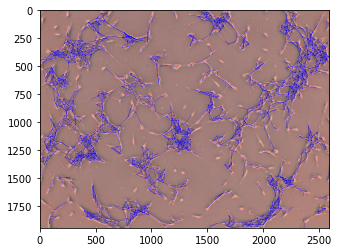

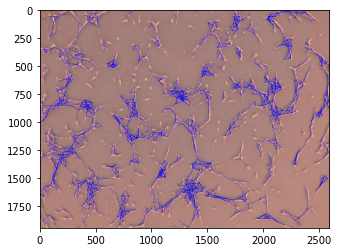

In [56]:
img_07 = cv2.imread('07_4/07_4.JPG')
img_21 = cv2.imread('21_4/21_4.JPG')
network21_4[0].visualize_adjacencies(img_21)
network07_4[0].visualize_adjacencies(img_07)

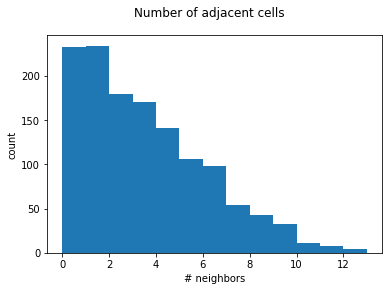

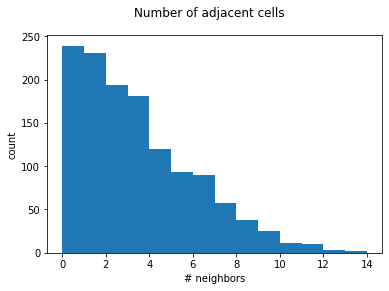

In [131]:
network21[0].plot_degree()
network7[0].plot_degree()

In [144]:
a = nx.coloring.greedy_color(network7[11].graph, strategy=nx.coloring.strategy_largest_first)
print(max(a.values()))
b = nx.coloring.greedy_color(network21[11].graph, strategy=nx.coloring.strategy_largest_first)
print(max(b.values()))

7
8


In [84]:
print(network21_4[0].density, network07_4[0].density)

0.00021277097482335185 0.00021312827284992338


In [127]:
#Temporary plotting cell:

big_list = [network7, network21]

average_connect = [[network.average_num_adjacencies() for network in network_list] for network_list in big_list]

cell_number = [[network.number for network in network_list] for network_list in big_list]
density = [[network.density for network in network_list] for network_list in big_list]
confidence = [[network.avgscore for network in network_list] for network_list in big_list]
variance = [[network.num_adjacencies_variance() for network in network_list] for network_list in big_list]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

bp=ax2.boxplot(average_connect, notch = True)

bp=ax1.boxplot(density, notch = True)

bp=ax3.boxplot(variance, notch = True)

bp=ax4.boxplot(confidence, notch = True)

ax1.set_title('Density')
ax2.set_title('Mean Degree')
ax3.set_title('Variance in Degree')
ax4.set_title('Segmentation Confidence')




AttributeError: 'network_object' object has no attribute 'average_num_adjacencies'

In [75]:
#Class object for network:
'''contains: the base image
the adjacency list
the graph
notable properties calculated on initialize
clustering (to be fixed) on call
visualization functions for graph on image and graph alone'''

class network_object:
    #network object - takes in a (full) segmentation output and initializes a network-object with notable properties calculated
    #
    
    def __init__(self, instances, tag, img = None):
        
        self.image = img
        self.instances = instances
        self.tag = tag
        
        #boxes = np.array(instances['pred_boxes'])
        #polygons = np.array(instances['pred_masks'])
        #scores = np.array(instances['scores'])
        
        self.number = len(self.instances['pred_boxes'])
        self.density = self.number/(instances['image_size'][0]*instances['image_size'][1])
        self.avgscore = sum(self.instances['scores'])/self.number
        
        self.densityHistogram = 0
        self.centroid_list = self.construct_centroid_list(self.instances)
        #self.polygon_list = self.construct_polygon_list(self.instances)
        
        self.adjacency_list = self.construct_adjacencies(self.instances)
        
        self.graph = self.construct_graph(self.adjacency_list)
        
        
        
    def construct_centroid_list(self, instances):
        return np.array([ (((box[0]+box[2])/2).item() , ((box[1]+box[3])/2).item()) for box in instances["pred_boxes"] ])
    
    def construct_polygon_list(self, instances):
        return [ np.reshape(mask[0], (int(len(mask[0])/2) , 2)) for mask in instances["pred_masks"] ]
        
    def construct_adjacencies(self, instances, mindist = 25):
        #takes a list of n cell_poly objects
        #takes a minimum distance defined as adjacent
        #returns an adjacency list of length n

        adjacency_list = []
        wide_list = []

        centroid_list = [ (((box[0]+box[2])/2).item() , ((box[1]+box[3])/2).item()) for box in instances["pred_boxes"] ]
        centroid_list = np.array(centroid_list)
        polygon_list = [ np.reshape(mask[0], (int(len(mask[0])/2) , 2)) for mask in instances["pred_masks"] ]

        tree = []
        tree = KDTree(centroid_list, leaf_size=10)

        wide_list = tree.query_radius(centroid_list, mindist * 5)

        for i,small_list in enumerate(wide_list):
            adjacency_list.append (list())
            for index in small_list:
                # if we've already explored this pair then skip (as cdist _should_ be symmetrical)
                if index <= i:
                    continue
                d = distance.cdist(polygon_list[i],polygon_list[index],'euclidean')
                if min(d.flatten()) < mindist:
                    adjacency_list[i].append (index)

        return adjacency_list
        
    def construct_graph(self, adjacency_list):
        g = nx.Graph()
        for i in range(len(adjacency_list)):
            g.add_node(i)

        for a in range(len(adjacency_list)):
            for b in adjacency_list[a]:
                if g.has_edge(a,b):
                    continue
                g.add_edge(a,b)
        return g
    
    def average_degree(self):
        return sum([len(sublist) for sublist in self.adjacency_list])/self.number
                                                                         
    def degree_variance(self):
        numadj = [len(sublist) for sublist in self.adjacency_list]
        return statistics.variance(numadj)
        
    def plot_degree(self):
        num_adjacencies = [len(sublist) for sublist in self.adjacency_list]
        fig = plt.figure()
        plt.hist(num_adjacencies, max(num_adjacencies))
        fig.suptitle('Number of adjacent cells')
        plt.xlabel('# neighbors')
        plt.ylabel('count')
        
    def visualize_adjacencies(self, img = None, savefig = 0):
        fig, ax = plt.subplots()
        if self.image is None and img is None:
            return 0
        elif self.image is None:
            ax.imshow(img, cmap=plt.cm.gray)
        else:
            ax.imshow(self.image, cmap=plt.cm.gray)
        
        for a,i in enumerate(self.adjacency_list):
            for b in i:
                plt.plot([self.centroid_list[a][0],self.centroid_list[b][0]], [self.centroid_list[a][1],self.centroid_list[b][1]], color = 'b', linewidth = .2)
        if savefig != 0:
            plt.savefig('out.png', bbox_inches='tight', dpi = 300)
        plt.show()
        
    def visualize_graph(self):
        nx.draw_networkx(self.graph, node_size = 5, node_color = 'r' , width = .5, font_size = 8, with_labels = True)
    
    def pickle_object(self):
        #pickle the whole object
        return 0

In [101]:
#Class object for Lineage Data:
'''
For one cell lineage over multiple passages
contains in level:
cell lineage - tag
list of passages
list of days
list of network objects

'''

class lineage:
    #lineage: reads in data from instances arranged in file tree as:
        #passages
            #days
                #instances - read in and intialize network_object
                #images(optional)
    
    
    def __init__(self, filepath, tag):
        
        self.tag = tag
        
        self.items = self.read_in(filepath)
        
    def read_in(self, filepath):
        result = []
        for passage_path in sorted(glob.glob(filepath+'/*/')):
            print(passage_path)
            days = []
            for day_path in sorted(glob.glob(passage_path+'*/')):
                networks = []
                for instance_path in sorted(glob.glob(day_path+'*.data')):
                    instances = {}
                    with open(instance_path, 'rb') as filehandle:
                        instances = pickle.load(filehandle)
                    print(instance_path)
                    networks.append(network_object(instances, file))
                days.append(networks)
            result.append(days)
        return result
    

    def pickle_object(self):
        #pickle the whole object
        return 0

In [102]:
toppath = "/Users/trevorchan/Desktop/test_tree_7"

lineage_7 = lineage(toppath, 'lineage_7')

/Users/trevorchan/Desktop/test_tree_7/p4/
/Users/trevorchan/Desktop/test_tree_7/p4/d3/instances1365.data
/Users/trevorchan/Desktop/test_tree_7/p4/d3/instances1369.data
/Users/trevorchan/Desktop/test_tree_7/p4/d3/instances1372.data
/Users/trevorchan/Desktop/test_tree_7/p4/d3/instances1380.data
/Users/trevorchan/Desktop/test_tree_7/p4/d3/instances1355.data
/Users/trevorchan/Desktop/test_tree_7/p4/d3/instances1359.data
/Users/trevorchan/Desktop/test_tree_7/p4/d3/instances1374.data
/Users/trevorchan/Desktop/test_tree_7/p4/d3/instances1357.data
/Users/trevorchan/Desktop/test_tree_7/p4/d3/instances1382.data
/Users/trevorchan/Desktop/test_tree_7/p4/d3/instances1367.data
/Users/trevorchan/Desktop/test_tree_7/p4/d3/instances1384.data
/Users/trevorchan/Desktop/test_tree_7/p4/d3/instances1370.data
/Users/trevorchan/Desktop/test_tree_7/p4/d4/instances1559.data
/Users/trevorchan/Desktop/test_tree_7/p4/d4/instances1555.data
/Users/trevorchan/Desktop/test_tree_7/p4/d4/instances1562.data
/Users/trevor

07_4/instances_07_4.data


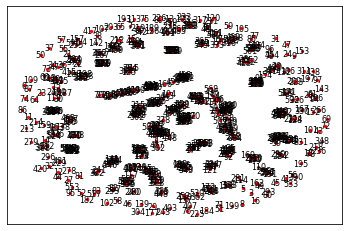

In [129]:
lineage_7.items[0][1][2].visualize_graph()
print(lineage_7.items[0][1][2].tag)


In [26]:
if nx.is_connected(g) != True:
    components_g = nx.connected_components(g)

gc = []
i = 0
min_nodes_requirement = 20

for component in components_g:
    temp_graph = nx.Graph()
    
    temp_graph.add_nodes_from(component)
    for a in range(len(adjacency_list)):
        for b in adjacency_list[a]:
            if temp_graph.has_edge(a,b):
                continue
            if temp_graph.has_node(a) and temp_graph.has_node(b):
                temp_graph.add_edge(a,b)
    print(len(temp_graph))
    if len(temp_graph) < min_nodes_requirement:
        continue
    gc.append(temp_graph)
    #print(component)
    i += 1

423
1
1
1
1
5
1
1
5
1
1
3
2


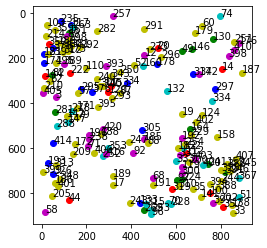

In [52]:
centroid_list = []
with open('centroid_list.data', 'rb') as filehandle:
    centroid_list = pickle.load(filehandle)

    
cluster_indices =  blocked
#print(cluster_indices)

scatter_x = [[centroid_list[index][0] for index in shortlist] for shortlist in cluster_indices]
scatter_y = [[centroid_list[index][1] for index in shortlist] for shortlist in cluster_indices]

#print(scatter_x,scatter_y)

group = np.array([])
for i in range(len(cluster_indices)):
    a = np.full((len(cluster_indices[i])),i)
    group = np.append(group,a,0)
group = group.flatten()
group = group.astype(int)

cdict = {0: 'r', 1: 'g', 2: 'b', 3: 'c', 4: 'm', 5: 'y', 6: 'k', 7: 'lightgreen'}


fig, ax = plt.subplots()
for i in range(len(scatter_x)):
    #print((max(ix)-min(ix)))
    ax.scatter(scatter_x[i], scatter_y[i], c = cdict[i])
    for j, txt in enumerate(cluster_indices[i]):
        ax.annotate(txt, (scatter_x[i][j], scatter_y[i][j]))

plt.axis('scaled')
plt.gca().invert_yaxis()
#plt.show()
#plt.savefig('clustersout.png', bbox_inches='tight')



In [183]:
with open('cluster_indices.data', 'wb') as filehandle:
    pickle.dump(blocked, filehandle)

In [231]:
barbellblock

[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9]]